In [3]:
pip install boruta

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.9/57.9 kB 2.4 MB/s eta 0:00:00


In [9]:
pip install feature_engine

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 375.0/375.0 kB 5.8 MB/s eta 0:00:00


In [2]:
import pandas as pd
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from boruta import BorutaPy
import shap
from feature_engine.selection import DropCorrelatedFeatures

In [4]:
# 타이타닉데이터로 보루타 알고리즘으로 피처를 선정하자!

df = sns.load_dataset('titanic')

#데이터 전처리

df = df.dropna(subset=['age','embarked','deck'])
df['sex'] =df['sex'].map({'male':0,'female':1})
df['embarked'] =df['embarked'].astype('category').cat.codes
df['deck'] = df['deck'].astype('category').cat.codes

#필요한 피처만 추출

X = df[['pclass','sex','age','sibsp','parch','fare','embarked','deck']]
y = df['survived']

In [5]:
## 보루타를 통한 피처셀렉션을 위해 RandomForestClassifier

rf= RandomForestClassifier(class_weight = 'balanced', max_depth=5)

# BorutaPy 불러오기
boruta_selector = BorutaPy(rf, n_estimators = 'auto', random_state=111)
boruta_selector.fit(X.values, y.values) #행렬로 대입해서

BorutaPy(estimator=RandomForestClassifier(class_weight='balanced', max_depth=5,
                                          n_estimators=80,
                                          random_state=RandomState(MT19937) at 0x19FA5167E40),
         n_estimators='auto',
         random_state=RandomState(MT19937) at 0x19FA5167E40)

In [6]:
print('선택된 특성',X.columns[boruta_selector.support_].tolist())

선택된 특성 ['sex', 'age', 'fare']


- 모든 특성의 중요들 평가하고, 쉐도우 변수를 만들어서 중요도가 무작위로 중요도를 뽑아서 비교하고
- 이 무작위보다 높은 중요도가 높은 특성들을 추출한 것

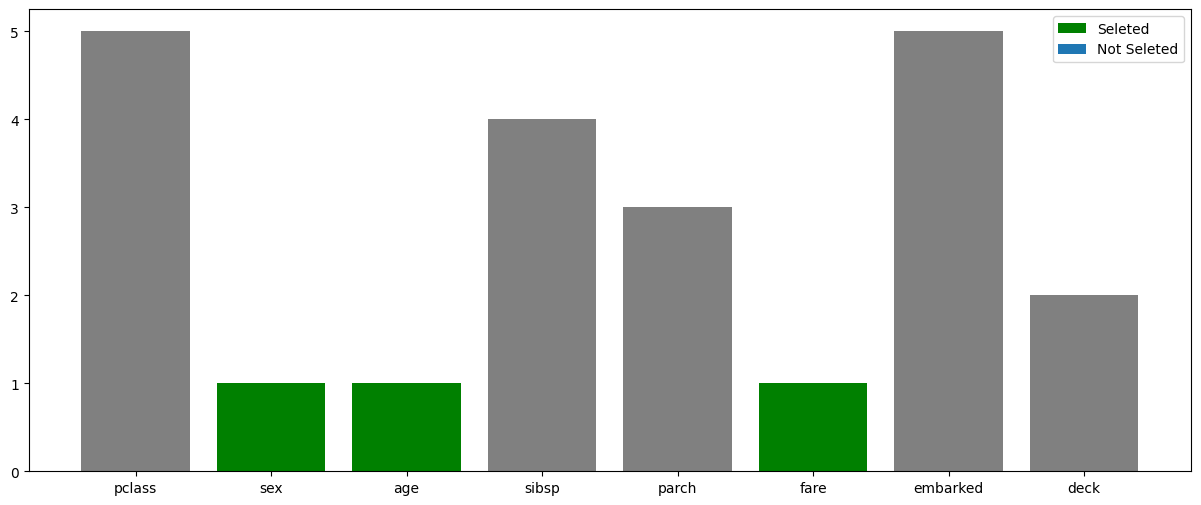

In [7]:
import matplotlib.pyplot as plt

green_area = X.columns[boruta_selector.support_].tolist()
blue_area = X.columns[boruta_selector.support_weak_].tolist()

# 중요도 랭킹으로 확인하기
feature_importance = boruta_selector.ranking_

# 시각화로 살펴보기

plt.figure(figsize=(15,6))
plt.bar(X.columns, feature_importance,color= 'grey')
plt.bar(green_area, [1]*len(green_area), color='green', label='Seleted')
plt.bar(blue_area, [2]*len(blue_area), color='blue', label='Not Seleted')
plt.legend()

## Shap vlaue( 샤플리 값 )
- 샤플리 값의 작동 방식을 이해하자!
- 간단한 예시를 통해 어떤 식으로 계산하는지 이해하기!
    - 세 명의 플레이어(피처) A, B, C가 협력해서 100의 매출들 달성 ( ML y값을 예측한다.)
    - A와 B가 같이 협력을 하면 매출을 60을 달성
    - B와 C가 같이 협력을 하면 매출을 50을 달성
    - A, B,C 가 모두 협력하면 100을 달성
    
    - 기여도는 어떤 식으로 계산이 될까?
        - 각 조합의 기여도를 계산
        - 공집합 = 기여도가 0 A,B,C 모두 진행 X
        - A만 한 경우 20, B만한 경우 30, C만 경우 10
        - A,B = 60, B,C = 50, A,C = 40
        - A,B,C = 100
    -샤플리 값 A를 계산한다고 하면 샤플리값 =  1/6(20) +  1/6(10) + 1/6(40-10) + 1/6(60-30) + 1/6(100-60)

- Machine Learning 에서 샤플리 값을 계산한다면?
    - **Feature 모델의 예측값에 기여한 정도를 계산하기 위해 샤플리값을 사용한다.**
    - **피처들의 조합으로 게임 플레이어처럼 생각하고, 모델의 예측값을 협력의 결과로 본다.**
    
    - 데이터 포인트에 대해 모델의 예측값 계산
    - 모든 특성의 조합에서의 예측값이 변화를 계산
    - 각 특성의 기여도를 평균화하여서 샤플리 값을 계산

### 샤플리 값을 타이타닉 데이터로 설명을 해보면!
- 타이타닉의 주요 특성(피처) pclass, sex, age, fare 타겟변수는 survived
- 랜덤포레스트를 학습해서 특정 포인트에서 샤플리값을 계산해 본다.


----
- 특성 N은
    - Pclass(객실등급), Sex(성별), Age(나이), Fare(요금)
    
- **모든 특성의 조합을 생각해야 한다.**
    - 공집합,
    - Pclass
    - Sex
    - Age
    - Fare
    - (Pclass, Sex)
    - ...
    - (Pclass, Sex, Age, Fare)
    - 모든 조합을 생성한다.
    
- 모델의 예측값을 계산
    - 수식에서 바라보면
    - S = pclass i = sex , pclass와 sex를 함께 사용하여 예측값을 계산
    - f(SU{i} - f(S}) 특성인 sex 추가가 되었을 때 예측값에 미친 변화량을 계산

- 평균화
    - 모든 부분집합 (S)에 대한 기여도를 계산하는 것, 이를 평균화하여 특성 (i) 샤플리 값을 얻는 것

- 특정 데이터 포인트에 대해 샤플리값을 디 다계산이 된다.
- 변수     샤플리값     해석
- pclass  -0.3     낮은 객실등급들이 생존 확률을 감소시킨다.
- sex     +0.5     여성의 경우 생존확률 증가시킨다.
- age     -0.2     나이가 많아질수록 생존에 대한 확률이 감소
- fare    +0.1     운임이 높으면 생존확률을 증가시킨다.

    **- 타이타닉의 도메인을 이해하고 샤플리값을 바라보면 피처에 대한 선택과 인사이트를 상대적으로 쉽게 정리할 수 있다.**
    

In [8]:
from sklearn.model_selection import train_test_split

X= df[['sex','age','fare','pclass']]
y= df['survived']

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3, random_state=111)

In [10]:
model = RandomForestClassifier(random_state=111)
model.fit(X_train, y_train)

RandomForestClassifier(random_state=111)

In [11]:
# Shap 값 구하기
# SHAP Explainer

explainer=shap.TreeExplainer(model)

In [12]:
# shap_values 추출
shap_values=explainer.shap_values(X_test)

In [13]:
shap_values

array([[[ 2.21466861e-01, -2.21466861e-01],
        [ 1.13594209e-01, -1.13594209e-01],
        [-2.06209208e-01,  2.06209208e-01],
        [-2.69185556e-04,  2.69185556e-04]],

       [[-1.50051199e-01,  1.50051199e-01],
        [-7.65689293e-02,  7.65689293e-02],
        [-6.35779054e-02,  6.35779054e-02],
        [-2.12192893e-02,  2.12192893e-02]],

       [[ 3.06207651e-01, -3.06207651e-01],
        [ 3.82706060e-02, -3.82706060e-02],
        [ 2.08374207e-01, -2.08374207e-01],
        [ 5.73021357e-03, -5.73021357e-03]],

       [[-1.94451182e-01,  1.94451182e-01],
        [-5.48092467e-02,  5.48092467e-02],
        [-6.84494051e-02,  6.84494051e-02],
        [-3.70748949e-03,  3.70748949e-03]],

       [[ 2.00072782e-01, -2.00072782e-01],
        [-3.04022517e-02,  3.04022517e-02],
        [-1.16545064e-01,  1.16545064e-01],
        [-4.54278848e-03,  4.54278848e-03]],

       [[-1.70773447e-01,  1.70773447e-01],
        [-7.32136894e-02,  7.32136894e-02],
        [-7.22896634e-

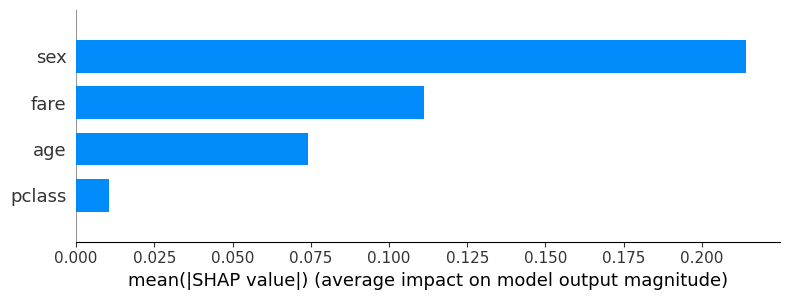

In [14]:
# 특정 클래스 선택 (예: 클래스 0)
shap_values_class_0 = shap_values[:, :, 0]

# 요약 플롯 생성
shap.summary_plot(shap_values_class_0, X_test, plot_type='bar', feature_names=X_test.columns.tolist())



TypeError: only integer scalar arrays can be converted to a scalar index

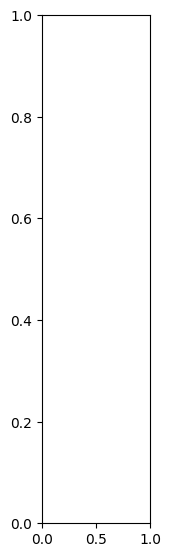

In [37]:
feature_names = X_test.columns.tolist()  # X_test가 DataFrame일 경우
shap.summary_plot(shap_values, X_test, plot_type='bar', feature_names=feature_names)




In [29]:
## shap 요약할 수 있는 시각화 플롯
shap.summary_plot(shap_values[0], X_test, plot_type='bar', feature_names= X_test.columns.tolist())

AssertionError: The shape of the shap_values matrix does not match the shape of the provided data matrix.

## 필수과제1
- 모델을 단순하게 RandomForest만 학습
- 타이타닉 데이터를 RF모델을 튜닝하여 과적합을 최소화 하여 하이퍼 파라미터를 찾고, 해당 하이퍼파라미터를 가지고 다시 한 번 샤플리를 진행해서
- 기존 베이스 모델의 샤플리값과 과적합을 최소화한 모델의 하이퍼파라미터로 샤플리값을 추출하는 것
- 둘을 비교해 주시면 됩니다.
    - **필수적으로**
    - 과적합을 최소화했다는 기준
        - 성능?
        - 그리드 서치 등을 통해 찾은 것인지?
        - 시각화 등으로도 보여주면서 과적합을 최소화 했다는 것을 코드와 함께 설명해 주셔야 합니다.